In [1]:
import keras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.activations import *
from keras.layers import Reshape 

In [3]:
import seaborn as sns
import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [99]:
import os 
from os import listdir
from tqdm import tqdm
import shutil
import cv2

import keras 
from keras import Model
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

from math import *

In [5]:
size = 224

In [6]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [7]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [8]:
#code used for creating directories
'''
size= 224
os.mkdir('augmented')
os.mkdir('./augmented/benign')
os.mkdir('./augmented/malignant')
'''

"\nsize= 224\nos.mkdir('augmented')\nos.mkdir('./augmented/benign')\nos.mkdir('./augmented/malignant')\n"

In [6]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [10]:
#code used for splitting Images into directories
'''
files_benign = getListOfFiles(r'D:\Breast Cancer Detection - Minor Project\BreakHis dataset\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')
        
files_malignant = getListOfFiles(r'D:\Breast Cancer Detection - Minor Project\BreakHis dataset\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')
'''

"\nfiles_benign = getListOfFiles(r'D:\\Breast Cancer Detection - Minor Project\\BreakHis dataset\\BreaKHis_v1\\BreaKHis_v1\\histology_slides\x08reast\x08enign')\nfor f in files_benign:\n    if f.endswith('.png'):\n        shutil.copy(f,'augmented/benign')\n        \nfiles_malignant = getListOfFiles(r'D:\\Breast Cancer Detection - Minor Project\\BreakHis dataset\\BreaKHis_v1\\BreaKHis_v1\\histology_slides\x08reast\\malignant')\nfor f in files_malignant:\n    if f.endswith('.png'):\n        shutil.copy(f,'augmented/malignant')\n"

In [7]:
benign_images = getListOfFiles('./augmented/benign')
malignent_images = getListOfFiles('./augmented/malignant')

In [8]:
total_images = len(benign_images) + len(malignent_images)
total_images

7909

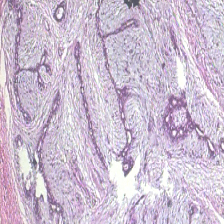

In [28]:
load_img(benign_images[548], target_size=(size,size,1))

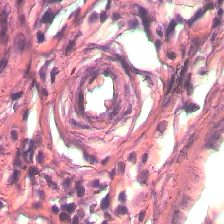

In [18]:
load_img(malignent_images[5428], target_size=(size,size,1))

In [10]:
data = pd.DataFrame(index=np.arange(0, len(benign_images)+len(malignent_images)), columns=["image", "target"])
k=0
for c in [0,1]:
        if c==1:
            for m in range(len(benign_images)):
                data.iloc[k]["image"] = benign_images[m]
                data.iloc[k]["target"] = 0
                k += 1
        else:
            for m in range(len(malignent_images)):
                data.iloc[k]["image"] = malignent_images[m]
                data.iloc[k]["target"] = 1
                k += 1
print(data.shape)
print(data.head())

C:\Users\Jack Kevin\AppData\Local\Temp\ipykernel_21028\4209343107.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.iloc[k]["image"] = malignent_images[m]
C:\Users\Jack Kevin\AppData\Local\Temp\ipykernel_21028\4209343107.py:12: Futur

(7909, 2)
                                               image target
0  ./augmented/malignant\SOB_M_DC-14-10926-100-00...      1
1  ./augmented/malignant\SOB_M_DC-14-10926-100-00...      1
2  ./augmented/malignant\SOB_M_DC-14-10926-100-00...      1
3  ./augmented/malignant\SOB_M_DC-14-10926-100-00...      1
4  ./augmented/malignant\SOB_M_DC-14-10926-100-00...      1


C:\Users\Jack Kevin\AppData\Local\Temp\ipykernel_21028\4209343107.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.iloc[k]["image"] = benign_images[m]
C:\Users\Jack Kevin\AppData\Local\Temp\ipykernel_21028\4209343107.py:7: FutureWarn

In [11]:
count_data = data["target"].value_counts()
count_data

target
1    5429
0    2480
Name: count, dtype: int64

In [12]:

ben_upsampled = resample(data[data['target']==0],n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()


target
1    5429
0    5429
Name: count, dtype: int64

In [12]:
    ''' 
    from sklearn.utils import resample

    # Separate the majority and minority classes
    majority_class = data[data['target'] == 1]  # Malignant class (more samples)
    minority_class = data[data['target'] == 0]  # Benign class (fewer samples)

    # Downsample the majority class to match the minority class
    majority_downsampled = resample(majority_class,
                                    replace=False,  # No replacement, to sample without duplication
                                    n_samples=len(minority_class),  # Match minority class count
                                    random_state=42)  # For reproducibility

    # Combine the downsampled majority class with the minority class
    downsampled_data = pd.concat([majority_downsampled, minority_class])

    # Shuffle the resulting dataset (optional but recommended)
    downsampled_data = downsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Check the class distribution after downsampling
    print(downsampled_data['target'].value_counts())
'''

target
0    2480
1    2480
Name: count, dtype: int64


In [13]:
kf = KFold(n_splits=10,random_state=42, shuffle=True)

train_image = []
y = []

for i in tqdm(range(downsampled_data.shape[0])):
    img_path = downsampled_data['image'].iloc[i]
    label = downsampled_data['target'].iloc[i]
    
    img = tf.keras.utils.load_img(img_path, target_size=(size, size))
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0  # Normalize the image
    train_image.append(img)
    y.append(label)

# Convert lists to numpy arrays
X = np.array(train_image)
y = np.array(y)



for train_index, test_index in kf.split(X,y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], \
                                       y[train_index], y[test_index]
    #print('train: %s, test: %s' % (X[train_index], X[test_index]))

for train_index, test_index in kf.split(X_test,y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], \
                                       y_test[train_index],y_test[test_index]
    

Y_train = y_train
Y_test = y_test
Y_val = y_val

#currently not using one hot encoding
'''
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y2_test, 2)
Y_val = np_utils.to_categorical(y_val, 2)
'''"BreakHis dataset"


# Print dataset shapes
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X2_test.shape)

100%|██████████| 4960/4960 [02:20<00:00, 35.36it/s]


Training set: (4464, 224, 224, 3)
Validation set: (49, 224, 224, 3)
Test set: (447, 224, 224, 3)


In [12]:
# Create directory to save numpy arrays
'''
save_dir = 'split_data'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save images and labels
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
np.save(os.path.join(save_dir, 'X_val.npy'), X_val)

np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
'''

In [15]:
print(Y_train)

[0 1 1 ... 0 0 1]


In [14]:
my_input= Input(shape=(size, size, 3))
img_shape= (size, size, 3)

DATA AUGMENTATION

In [22]:
'''
data_gen = ImageDataGenerator(
        zoom_range=1.2,  # set range for random zoom
        rotation_range = 90,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
'''

'\ndata_gen = ImageDataGenerator(\n        zoom_range=1.2,  # set range for random zoom\n        rotation_range = 90,\n        width_shift_range=0.5,\n        height_shift_range=0.5,\n        horizontal_flip=True,  # randomly flip images\n        vertical_flip=True,  # randomly flip images\n    )\n'

In [15]:
def adjust_contrast(image):
    # Adjust contrast by a factor. You can change the factor as needed.
    return tf.image.adjust_contrast(image, contrast_factor=1.4)


data_gen = ImageDataGenerator(
        zoom_range=[0.99, 1.01],  # set range for random zoom
        brightness_range=[0.9, 1.01],
        rotation_range=90,
        shear_range=1.2,
        data_format="channels_last",
        fill_mode="reflect",
        channel_shift_range=50,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        preprocessing_function= adjust_contrast # randomly flip images
    )

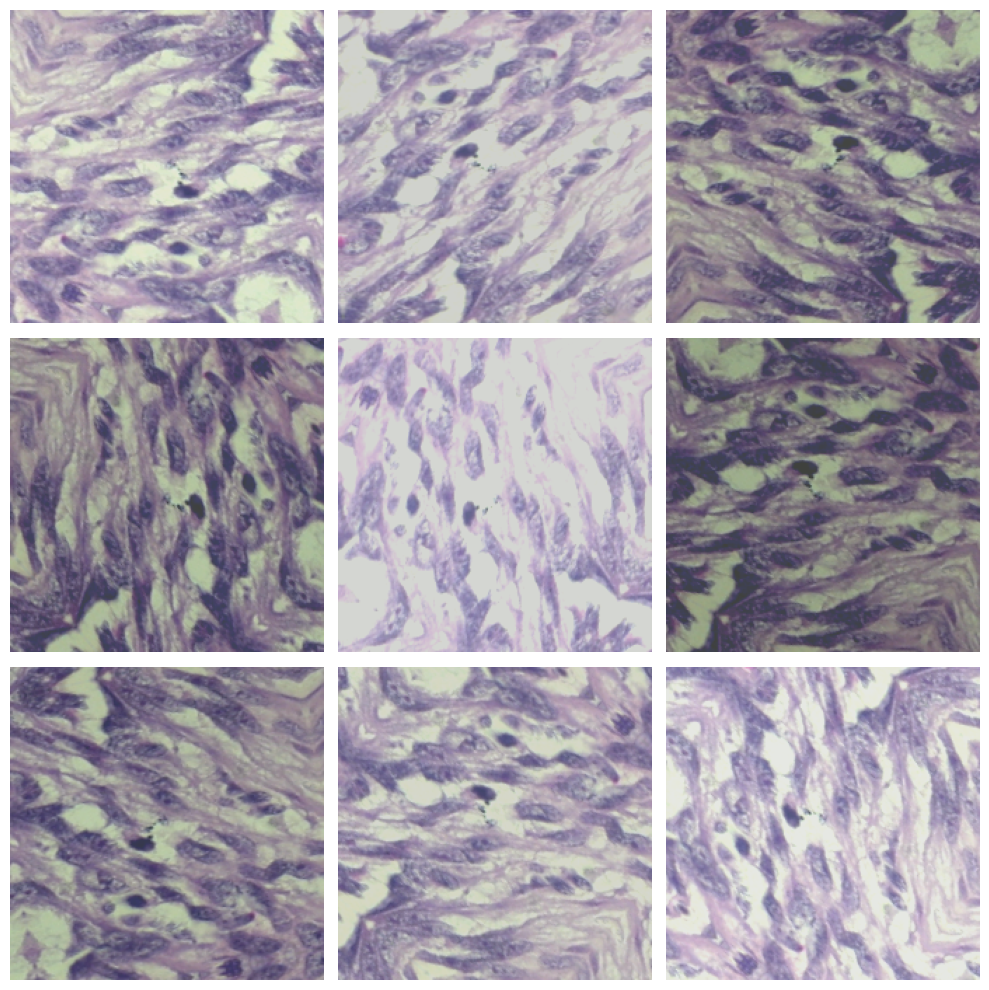

In [29]:
img = tf.keras.utils.load_img(benign_images[789], target_size=(size,size,1))  # Adjust target size as needed
x = tf.keras.utils.img_to_array(img)  # Convert image to array
x = np.expand_dims(x, axis=0)  # Reshape to (1, height, width, channels)

# Generate augmented images
i = 0
plt.figure(figsize=(10, 10))
for batch in data_gen.flow(x, batch_size=1):
    plt.subplot(3, 3, i + 1)  # Arrange images in a grid (3x3)
    plt.imshow(batch[0].astype('float32') / 255)  # Normalize the pixel values for display
    plt.axis('off')
    i += 1
    if i >= 9:  # Display 9 augmented images and then break
        break

plt.tight_layout()
plt.show()

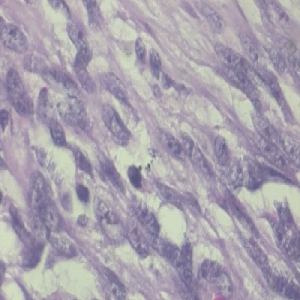

In [17]:
tf.keras.utils.load_img(benign_images[789], target_size=(300,300,1))

In [30]:
data_gen.fit(X_train)
X_train.shape[0]
data_gen.fit(X_val)
X_val.shape[0]
data_gen.fit(X2_test)
X2_test.shape[0]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4464, 224, 224, 3)
(49, 224, 224, 3)
(496, 224, 224, 3)


USE GPU(s) IF AVAILABLE

In [27]:
import GPUtil

# Get the first GPU in the system
gpu = GPUtil.getGPUs()[0]

print(f"GPU Memory Total: {gpu.memoryTotal}MB")
print(f"GPU Memory Free: {gpu.memoryFree}MB")
print(f"GPU Memory Used: {gpu.memoryUsed}MB")
print(f"Temp: {gpu.temperature}")

GPU Memory Total: 4096.0MB
GPU Memory Free: 3698.0MB
GPU Memory Used: 238.0MB
Temp: 61.0


In [28]:
# Check GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Set TensorFlow to use GPU devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
         
        # Enable memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is ready")
    except RuntimeError as e:
        print(e)

In [19]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, multiply
from tensorflow.keras import backend as K

MODEL BUILDING:

In [88]:
import tensorflow as tf
from tensorflow.keras import layers, models

def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation Block for feature recalibration."""
    filters = input_tensor.shape[-1]
    
    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(input_tensor)

    # Excitation
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    
    # Reshape and scale
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([input_tensor, se])

Detailed version:

In [ ]:
#the conv_block is the resnet50 architecture
'''
def conv_block(input_layer, filters):
    """Convolutional Block with Batch Normalization and ReLU."""
    #1x1 conv2D (reduce)
    layer = layers.Conv2D(filters, kernel_size=1, strides=1,
                          padding='same', kernel_initializer='he_normal',
                          use_bias=False)(input_layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)

    #3x3 conv2D (main convolution)
    layer = layers.Conv2D(filters, kernel_size=3, strides=1,
                          padding='same', kernel_initializer='he_normal',
                          use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)

    #1x1 conv2D (restore)
    layer = layers.Conv2D(filters * 4, kernel_size=1, strides=1,
                          padding='same', kernel_initializer='he_normal',
                          use_bias=False)(layer)
    layer = layers.BatchNormalization()(layer)
    return layers.ReLU()(layer)
'''

In [32]:
'''
def SE_ResNet50(input_shape=(size, size, 3), classes=1):
    #BUILDS THE SQUEEZE-AND-EXCITATION RESNET50 MODEL FOR BINARY CLASSIFICATION
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Define the ResNet blocks with Squeeze and Excitation
    blocks_per_stage = [3, 4, 6, 3]  # ResNet50 block configuration

    for filters, blocks in zip([64, 128, 256, 512], blocks_per_stage):
        for _ in range(blocks):  # Number of blocks per stage
            shortcut = x
            
            # First convolution block
            x = conv_block(x, filters)
            x = squeeze_excite_block(x)  # Add SE block here
            
            # Adjust shortcut if necessary
            if shortcut.shape[-1] != filters * 4:
                shortcut = layers.Conv2D(filters * 4, (1, 1), padding='same')(shortcut)

            # Add shortcut connection
            x = layers.add([x, shortcut])
            x = layers.ReLU()(x)

    # Final Layers
    x = layers.GlobalAveragePooling2D()(x)
    
    # Output Layer for binary classification
    outputs = layers.Dense(classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    
    return model
'''

Simpler Version:

In [97]:
def build_se_resnet50(input_shape=(224, 224, 3)):
    # Load the ResNet50 model with ImageNet weights
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Create an input layer
    inputs = layers.Input(shape=input_shape)
    
    # Pass input through the base model
    x = base_model(inputs)
    
    # Layer 1
    x = squeeze_excite_block(x)  # Apply SE block after layer
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.5)(x)  # 50% dropout
    
    # Fully connected layer for output
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model

In [100]:
# Define constants
IMG_HEIGHT = size  # Adjust based on your dataset
IMG_WIDTH = size  # Adjust based on your dataset

# Create the model
model = build_se_resnet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


'''
# Freeze all layers first
for layer in model.layers:
    layer.trainable = False


# Unfreeze more layers for fine-tuning
for layer in model.layers[:-1]:  # Unfreeze the last 30 layers for training
    layer.trainable = True
'''


'\n# Freeze all layers first\nfor layer in model.layers:\n    layer.trainable = False\n\n\n# Unfreeze more layers for fine-tuning\nfor layer in model.layers[:-1]:  # Unfreeze the last 30 layers for training\n    layer.trainable = True\n'

In [101]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_44[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 2048)      │    264,192 │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 1, 1,      │          0 │ dense_48[0][0]    │
│ (Reshape)           │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_15         │ (None, 7, 7,      │          0 │ resnet50[0][0],   │
│ (Multiply)          │ 2048)             │            │ reshape_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ multiply_15[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,376,577 (92.99 MB)

 Trainable params: 24,323,457 (92.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [61]:
# Define the EarlyStopping callback
from keras.callbacks import EarlyStopping
epochs = 30

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=epochs,              # Number of epochs with no improvement after which training will be stopped
    verbose = 1,
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

# Define the Learning Rate Scheduler callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=epochs,
    verbose=1,
    min_delta=0.0001)

csv_logger = keras.callbacks.CSVLogger('Model.log')

callbacks = [early_stopping, csv_logger, reduce_lr]


In [62]:
# Fit the model using the tf.data.Dataset pipeline
history = model.fit(
    X_train, Y_train,      # Training dataset
    epochs=30,          # Number of epochs
    validation_data=(X_val, Y_val),  # Validation dataset
    callbacks=callbacks,           # Callbacks if any 
)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1046s 7s/step - accuracy: 0.7730 - loss: 0.5181 - val_accuracy: 0.5306 - val_loss: 13.6182 - learning_rate: 0.0010
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 976s 7s/step - accuracy: 0.8695 - loss: 0.3286 - val_accuracy: 0.5306 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1013s 7s/step - accuracy: 0.8896 - loss: 0.2698 - val_accuracy: 0.4694 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1017s 7s/step - accuracy: 0.9122 - loss: 0.2093 - val_accuracy: 0.5714 - val_loss: 0.6808 - learning_rate: 0.0010
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1182s 8s/step - accuracy: 0.9273 - loss: 0.1819 - val_accuracy: 0.4490 - val_loss: 0.7775 - learning_rate: 0.0010
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1279s 9s/step - accuracy: 0.9324 - loss: 0.1712 - val_accuracy: 0.4082 - val_loss: 1.1943 - learning_rate: 0.0010
Epoch 7/30
123/140 ━━━━━━━━━━━━━━━━━━━━ 2:02 7s/step - accuracy: 0.9421 - lo

KeyboardInterrupt: 

In [ ]:
# Evaluate on the test data after training
test_loss, test_acc = model.evaluate(X2_test, Y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

In [ ]:
tf.keras.utils.plot_model(model, 
           show_shapes = True,
           show_dtype= True,
           show_layer_names = True,
           show_layer_activations= True,
            show_trainable= True,
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [126]:
#save model
'''
model.save()
'''

In [128]:
truey=[]
predy=[]
x = X2_test
y = Y_test

yhat= model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

31/31 [==============================] - 39s 947ms/step
Predicted and true label values saved
Accuracy on test set :99.48822927328557%


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


confusion_matrix_img(truey, predy, savename='Confusion Matrix')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('resnet_bcancer.h5')

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Lambda

def squeeze_excitation_layer(inputs, num_channels, ratio=16):
    squeeze = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=True))(inputs)
    excitation = Dense(num_channels // ratio, activation='relu')(squeeze)
    excitation = Dense(num_channels, activation='sigmoid')(excitation)
    return Lambda(lambda x: x[0] * x[1])([inputs, excitation])